Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  2785.54731239
Right lane curve radius:  2419.52353806
Left coeffs:  [  2.01349380e-04   1.31217200e-02   3.68769578e+02]
Right fit:  [  4.50778156e-04   2.23567851e-01   1.05552442e+03]


array([[[200, 153,  97],
        [200, 153,  97],
        [200, 153,  97],
        ..., 
        [197, 150,  88],
        [196, 149,  87],
        [194, 147,  85]],

       [[201, 154,  98],
        [200, 153,  97],
        [200, 153,  97],
        ..., 
        [196, 149,  87],
        [195, 148,  86],
        [194, 147,  85]],

       [[201, 154,  98],
        [201, 154,  98],
        [201, 154,  98],
        ..., 
        [196, 149,  87],
        [195, 148,  86],
        [195, 148,  86]],

       ..., 
       [[104,  89, 103],
        [104,  90, 104],
        [105,  91, 105],
        ..., 
        [100, 107, 126],
        [101, 108, 127],
        [ 97, 104, 123]],

       [[103,  91, 105],
        [104,  92, 106],
        [105,  92, 107],
        ..., 
        [ 99, 106, 125],
        [ 99, 106, 125],
        [ 97, 104, 123]],

       [[105,  94, 110],
        [105,  94, 110],
        [104,  94, 110],
        ..., 
        [100, 107, 126],
        [100, 107, 126],
        [100, 107,

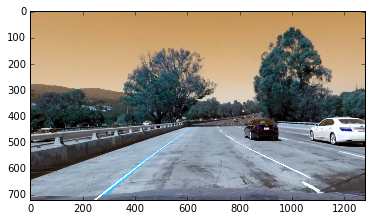

In [33]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from helperfunctions import *

with open("camera_calibration_result.p", mode='rb') as f:
    camera_calib = pickle.load(f)
mtx = camera_calib["mtx"]
dist = camera_calib["dist"]

def image_pipeline(file, filepath=False):
    
    if filepath == True:
        # Read in image
        raw = cv2.imread(file)
    else:
        raw = file

    # Parameters
    imshape = raw.shape

    src = np.float32(
        [[0, 720],
         [550, 470],
         [700, 470],
         [720, 1280]])

    dst = np.float32(
        [[200, 720],
         [200, 0],
         [900, 0],
         [900, 720]])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    height = raw.shape[0]
    offset = 50
    offset_height = height - offset
    half_frame = raw.shape[1] // 2
    steps = 6
    pixels_per_step = offset_height / steps
    window_radius = 200
    medianfilt_kernel_size = 51

    blank_canvas = np.zeros((720, 1280))

    # Apply distortion correction to raw image
    image = cv2.undistort(raw, mtx, dist, None, mtx)

    ## Option I
    combined = apply_thresholds(image)

    ## Option II

    combined_binary = apply_threshold_v2(image, xgrad_thresh=(40,100), s_thresh=(150,255))
#    plt.imshow(combined_binary, cmap="gray")

    # Plotting thresholded images
    """
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.set_title('Option 1')
    ax1.imshow(combined, cmap="gray")

    ax2.set_title('Option 2: Combined S channel and gradient thresholds')
    ax2.imshow(combined_binary, cmap='gray')
    """

    # Warp onto birds-eye-view
    # Previous region-of-interest mask's function is absorbed by the warp
    warped = cv2.warpPerspective(combined_binary, M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
    plt.imshow(warped, cmap="gray")


    # Histogram and get pixels in window

    leftx, lefty, rightx, righty = histogram_pixels(warped, horizontal_offset=40)

    left_fit, left_coeffs = fit_second_order_poly(lefty, leftx, return_coeffs=True)
    right_fit, right_coeffs = fit_second_order_poly(righty, rightx, return_coeffs=True)

    # Plot data
    """
    plt.plot(left_fit, lefty, color='green', linewidth=3)
    plt.plot(right_fit, righty, color='green', linewidth=3)
    plt.imshow(warped, cmap="gray")
    """
    # Determine curvature of the lane
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(lefty)
    left_curverad = ((1 + (2 * left_coeffs[0] * y_eval + left_coeffs[1]) ** 2) ** 1.5) \
                    / np.absolute(2 * left_coeffs[0])
    right_curverad = ((1 + (2 * right_coeffs[0] * y_eval + right_coeffs[1]) ** 2) ** 1.5) \
                     / np.absolute(2 * right_coeffs[0])
    print("Left lane curve radius: ", left_curverad)
    print("Right lane curve radius: ", right_curverad)

    # TODO: Det vehicle position wrt centre

    ## 7. Warp the detected lane boundaries back onto the original image.

    # plt.imshow(blank_canvas, cmap="gray")
    print("Left coeffs: ", left_coeffs)
    print("Right fit: ", right_coeffs)
    polyfit_left = draw_poly(blank_canvas, lane_poly, left_coeffs, 30)
#    plt.imshow(polyfit_left, cmap="gray")
    polyfit_drawn = draw_poly(polyfit_left, lane_poly, right_coeffs, 30)
#    plt.imshow(polyfit_drawn, cmap="gray")
#    plt.imshow(warped)
    lane_lines = cv2.warpPerspective(polyfit_drawn, Minv, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
    # plt.imshow(lane_lines, cmap="gray")

    # Convert to colour
    lane_line_colour = cv2.cvtColor(lane_lines.astype(np.uint8), cv2.COLOR_GRAY2RGB)

    combined_img = cv2.add(lane_line_colour, image)
    plt.imshow(combined_img)
    return combined_img

image_pipeline("test_images/test1.jpg", filepath=True)

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  2785.54731239
Right lane curve radius:  2419.52353806
Left coeffs:  [  2.01349380e-04   1.31217200e-02   3.68769578e+02]
Right fit:  [  4.50778156e-04   2.23567851e-01   1.05552442e+03]


array([[[200, 153,  97],
        [200, 153,  97],
        [200, 153,  97],
        ..., 
        [197, 150,  88],
        [196, 149,  87],
        [194, 147,  85]],

       [[201, 154,  98],
        [200, 153,  97],
        [200, 153,  97],
        ..., 
        [196, 149,  87],
        [195, 148,  86],
        [194, 147,  85]],

       [[201, 154,  98],
        [201, 154,  98],
        [201, 154,  98],
        ..., 
        [196, 149,  87],
        [195, 148,  86],
        [195, 148,  86]],

       ..., 
       [[104,  89, 103],
        [104,  90, 104],
        [105,  91, 105],
        ..., 
        [100, 107, 126],
        [101, 108, 127],
        [ 97, 104, 123]],

       [[103,  91, 105],
        [104,  92, 106],
        [105,  92, 107],
        ..., 
        [ 99, 106, 125],
        [ 99, 106, 125],
        [ 97, 104, 123]],

       [[105,  94, 110],
        [105,  94, 110],
        [104,  94, 110],
        ..., 
        [100, 107, 126],
        [100, 107, 126],
        [100, 107,

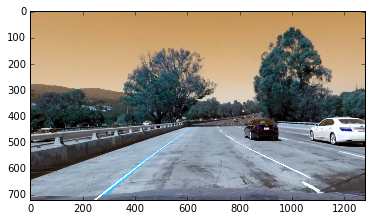

In [5]:
image_pipeline("test_images/test1.jpg")

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  4919.99107913
Right lane curve radius:  531.448013121
Left coeffs:  [ -1.03755785e-04   2.58683139e-01   3.49289955e+02]
Right fit:  [ -1.31183715e-03   1.28076128e+00   8.94378849e+02]


array([[[202, 168, 122],
        [202, 168, 122],
        [202, 168, 122],
        ..., 
        [202, 162, 109],
        [202, 162, 109],
        [202, 162, 109]],

       [[202, 168, 122],
        [202, 168, 122],
        [202, 168, 122],
        ..., 
        [202, 162, 109],
        [202, 162, 109],
        [202, 162, 109]],

       [[202, 168, 122],
        [202, 168, 122],
        [202, 168, 122],
        ..., 
        [202, 162, 109],
        [202, 162, 109],
        [202, 162, 109]],

       ..., 
       [[ 91,  71,  54],
        [ 93,  73,  57],
        [ 95,  75,  60],
        ..., 
        [104, 111, 136],
        [103, 110, 135],
        [101, 108, 133]],

       [[ 90,  71,  56],
        [ 90,  71,  57],
        [ 92,  74,  60],
        ..., 
        [103, 110, 135],
        [103, 110, 135],
        [103, 110, 135]],

       [[ 95,  79,  66],
        [ 91,  75,  63],
        [ 88,  72,  61],
        ..., 
        [102, 110, 134],
        [102, 109, 134],
        [101, 108,

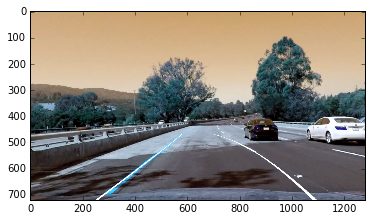

In [6]:
image_pipeline("test_images/test4.jpg")

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  5251.19382498
Right lane curve radius:  2176.50381769
Left coeffs:  [  9.92207803e-05   3.13290372e-02   3.17147107e+02]
Right fit:  [ -2.40379328e-04   5.03518724e-01   1.01577344e+03]


/Users/jessica/GitHub/self-driving-car-nd/p4-advanced-lane-lines/helperfunctions.py:281: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  histogram = np.sum(warped_thresholded_image[window_end_y:window_start_y, :], axis=0)
/Users/jessica/GitHub/self-driving-car-nd/p4-advanced-lane-lines/helperfunctions.py:222: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  window = img[y_center - half_size:y_center + half_size, x_center - half_size:x_center + half_size]


array([[[ 22,  40,  39],
        [ 14,  32,  31],
        [  8,  25,  24],
        ..., 
        [125, 103,  88],
        [121, 100,  85],
        [117,  97,  83]],

       [[ 29,  47,  46],
        [ 20,  38,  37],
        [ 11,  29,  28],
        ..., 
        [125, 101,  84],
        [119,  95,  78],
        [116,  93,  77]],

       [[ 25,  43,  43],
        [ 20,  38,  37],
        [ 14,  32,  31],
        ..., 
        [124,  98,  78],
        [119,  93,  74],
        [121,  97,  80]],

       ..., 
       [[ 44,  51,  76],
        [ 44,  51,  76],
        [ 45,  52,  77],
        ..., 
        [ 89,  94, 115],
        [ 89,  94, 115],
        [ 88,  93, 114]],

       [[ 47,  54,  79],
        [ 47,  54,  79],
        [ 48,  55,  80],
        ..., 
        [ 90,  96, 116],
        [ 91,  97, 117],
        [ 92,  97, 117]],

       [[ 50,  57,  82],
        [ 50,  57,  82],
        [ 51,  58,  83],
        ..., 
        [ 92,  97, 117],
        [ 93,  99, 118],
        [ 94, 100,

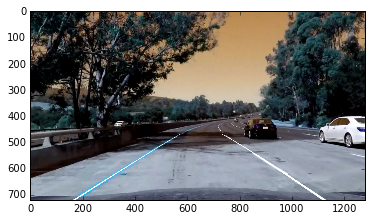

In [7]:
image_pipeline("test_images/test5.jpg")

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  4271.65444511
Right lane curve radius:  1943.53852744
Left coeffs:  [  1.19384561e-04  -4.43934773e-02   4.53846472e+02]
Right fit:  [  2.76390387e-03  -1.72562399e+00   1.43355861e+03]


array([[[196, 155, 116],
        [195, 154, 115],
        [195, 154, 115],
        ..., 
        [192, 150,  97],
        [192, 150,  97],
        [192, 150,  97]],

       [[196, 155, 116],
        [196, 155, 116],
        [196, 155, 116],
        ..., 
        [192, 150,  97],
        [192, 150,  97],
        [192, 150,  97]],

       [[196, 155, 116],
        [196, 155, 116],
        [196, 155, 116],
        ..., 
        [192, 150,  97],
        [192, 150,  97],
        [192, 150,  97]],

       ..., 
       [[ 63,  62,  88],
        [ 66,  65,  91],
        [ 66,  65,  91],
        ..., 
        [ 98, 105, 130],
        [ 95, 102, 127],
        [ 92,  99, 124]],

       [[ 66,  65,  91],
        [ 67,  66,  92],
        [ 67,  66,  92],
        ..., 
        [ 91,  98, 123],
        [ 91,  98, 123],
        [ 92,  99, 124]],

       [[ 69,  68,  94],
        [ 68,  67,  93],
        [ 69,  68,  94],
        ..., 
        [ 83,  90, 115],
        [ 85,  92, 117],
        [ 89,  96,

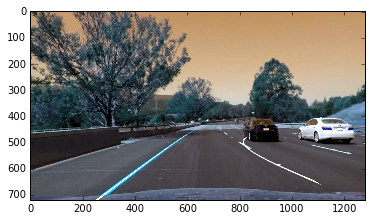

In [31]:
image_pipeline("test_images/test6.jpg")

In [27]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [28]:
def process_image(image):
    """Puts image through pipeline and returns 3-channel image for processing video below."""
    result = draw_lane_lines(image)
    print(result.shape)
    return result

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  3739.95012783
Right lane curve radius:  8305.09229519
Left coeffs:  [ -1.44521099e-04   4.22210131e-01   2.91667381e+02]
Right fit:  [  9.16437239e-05   4.47240102e-01   1.00635828e+03]
[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4



  1%|          | 1/126 [00:00<00:50,  2.47it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  3739.95012783
Right lane curve radius:  8305.09229519
Left coeffs:  [ -1.44521099e-04   4.22210131e-01   2.91667381e+02]
Right fit:  [  9.16437239e-05   4.47240102e-01   1.00635828e+03]


Step  0
Step  1
Step  2
Step  3
Step  4
Step  5



  2%|▏         | 2/126 [00:00<00:53,  2.32it/s]

Left lane curve radius:  2645.54332245
Right lane curve radius:  1690.58483286
Left coeffs:  [ -1.99598533e-04   4.56763287e-01   2.87944806e+02]
Right fit:  [ -3.49554082e-04   8.06117591e-01   9.32077889e+02]


Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  2956.5540632
Right lane curve radius:  3608.30004658
Left coeffs:  [ -1.80591628e-04   4.50625800e-01   2.89190217e+02]
Right fit:  [ -1.81146250e-04   6.82069516e-01   9.53363842e+02]



  2%|▏         | 3/126 [00:01<00:52,  2.35it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  2431.26423148
Right lane curve radius:  12557.0044716
Left coeffs:  [ -2.16812872e-04   4.76409239e-01   2.86681836e+02]
Right fit:  [ -5.82262807e-05   6.14044996e-01   9.58146376e+02]



  3%|▎         | 4/126 [00:01<00:51,  2.37it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  2153.6428099
Right lane curve radius:  3022.72309671
Left coeffs:  [ -2.43442382e-04   5.01558446e-01   2.81847288e+02]
Right fit:  [  5.36649662e-04   3.81045165e-01   9.78630519e+02]



  5%|▍         | 6/126 [00:02<00:49,  2.42it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  2117.50862212
Right lane curve radius:  2738.22612364
Left coeffs:  [ -2.47987242e-04   5.10082294e-01   2.80720398e+02]
Right fit:  [  8.65675371e-04   2.05422213e-01   9.99535253e+02]



  6%|▌         | 7/126 [00:02<00:47,  2.49it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  2330.34402637
Right lane curve radius:  2623.84830619
Left coeffs:  [ -2.27867782e-04   5.03099775e-01   2.79447419e+02]
Right fit:  [  8.27692268e-04   1.96672474e-01   1.00604054e+03]



  6%|▋         | 8/126 [00:03<00:47,  2.51it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  2547.80539659
Right lane curve radius:  605.240760737
Left coeffs:  [ -2.10647471e-04   4.98336853e-01   2.79131150e+02]
Right fit:  [ -8.62336714e-04   9.69659727e-01   9.16459996e+02]


Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  3093.33335472
Right lane curve radius:  3345.8014463
Left coeffs:  [ -1.76105325e-04   4.74973989e-01   2.79629142e+02]
Right fit:  [ -1.93979665e-04   6.91871642e-01   9.46924141e+02]



  7%|▋         | 9/126 [00:03<00:46,  2.51it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  2756.70883723
Right lane curve radius:  2258.98487006
Left coeffs:  [ -1.96478898e-04   4.93382595e-01   2.74575781e+02]
Right fit:  [  7.46896855e-04   1.32022282e-01   1.02924517e+03]



  9%|▊         | 11/126 [00:04<00:46,  2.45it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  2616.26326113
Right lane curve radius:  2792.96367029
Left coeffs:  [ -2.06771829e-04   5.05528990e-01   2.70806007e+02]
Right fit:  [  3.88387152e-04   3.08664764e-01   1.00809118e+03]


Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  2799.13681782
Right lane curve radius:  2624.58674513
Left coeffs:  [ -1.95429576e-04   5.06498612e-01   2.62790473e+02]
Right fit:  [ -2.35973492e-04   7.03112477e-01   9.52448590e+02]



 10%|▉         | 12/126 [00:04<00:46,  2.44it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  2626.39412497
Right lane curve radius:  1225.99761234
Left coeffs:  [ -2.07868257e-04   5.20478140e-01   2.59559480e+02]
Right fit:  [ -4.54301177e-04   8.73695711e-01   9.17955158e+02]



 10%|█         | 13/126 [00:05<00:46,  2.43it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  2456.5932382
Right lane curve radius:  5151.10554886
Left coeffs:  [ -2.22313112e-04   5.40071553e-01   2.54699756e+02]
Right fit:  [ -1.32004502e-04   6.51453745e-01   9.55229475e+02]



 11%|█         | 14/126 [00:05<00:45,  2.44it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  1987.41153749
Right lane curve radius:  11245.8960638
Left coeffs:  [ -2.68135875e-04   5.62788751e-01   2.54243298e+02]
Right fit:  [ -6.38548220e-05   6.06863631e-01   9.57557311e+02]



 12%|█▏        | 15/126 [00:06<00:46,  2.41it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  2451.22748602
Right lane curve radius:  10456.4028523
Left coeffs:  [ -2.22297517e-04   5.36790809e-01   2.58096894e+02]
Right fit:  [  8.58611292e-05   5.77370209e-01   9.35548162e+02]



 13%|█▎        | 16/126 [00:06<00:44,  2.45it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  2240.32562411
Right lane curve radius:  3617.52329126
Left coeffs:  [ -2.40600815e-04   5.54846338e-01   2.51625705e+02]
Right fit:  [  1.16940405e-03   1.80355890e-01   9.69647785e+02]



 13%|█▎        | 17/126 [00:06<00:44,  2.47it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  2408.03770381
Right lane curve radius:  16848.3901758
Left coeffs:  [ -2.26385216e-04   5.42840178e-01   2.54034126e+02]
Right fit:  [  4.56557856e-05   5.16419094e-01   9.44744676e+02]



 14%|█▍        | 18/126 [00:07<00:43,  2.48it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  2885.45553746
Right lane curve radius:  2791.64605442
Left coeffs:  [ -1.92085202e-04   5.20561698e-01   2.53338085e+02]
Right fit:  [  7.90147337e-04   2.55377592e-01   9.73186231e+02]



 15%|█▌        | 19/126 [00:07<00:45,  2.36it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  2859.90741198
Right lane curve radius:  4022.63655235
Left coeffs:  [ -1.94638741e-04   5.29659344e-01   2.47466980e+02]
Right fit:  [  2.48766391e-04   4.38032613e-01   9.63243361e+02]



 16%|█▌        | 20/126 [00:08<00:45,  2.34it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  5519.97781009
Right lane curve radius:  2781.06391448
Left coeffs:  [ -1.05549475e-04   4.67380329e-01   2.52150544e+02]
Right fit:  [ -2.23548437e-04   6.91341375e-01   9.36262019e+02]



 17%|█▋        | 21/126 [00:08<00:45,  2.31it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  9039.1497564
Right lane curve radius:  1334.46681275
Left coeffs:  [ -6.59804265e-05   4.40530108e-01   2.50932405e+02]
Right fit:  [ -3.97354561e-04   7.25961566e-01   9.43547590e+02]



 17%|█▋        | 22/126 [00:09<00:44,  2.32it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  5793.0466759
Right lane curve radius:  158585.108596
Left coeffs:  [ -1.01082482e-04   4.67106879e-01   2.43700939e+02]
Right fit:  [  4.54583828e-06   5.19581333e-01   9.73857367e+02]



 18%|█▊        | 23/126 [00:09<00:44,  2.32it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  9518.44821768
Right lane curve radius:  24837.5855687
Left coeffs:  [ -6.19426337e-05   4.22824859e-01   2.53716321e+02]
Right fit:  [ -2.81638473e-05   5.38183264e-01   9.70807792e+02]



 19%|█▉        | 24/126 [00:10<00:45,  2.26it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  8910.14880308
Right lane curve radius:  5861.12537113
Left coeffs:  [ -6.54554104e-05   4.15559006e-01   2.56485718e+02]
Right fit:  [  1.39534322e-04   4.38058399e-01   9.85271148e+02]



 20%|█▉        | 25/126 [00:10<00:43,  2.30it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  7276.79758043
Right lane curve radius:  1147.0687406
Left coeffs:  [ -7.97061424e-05   4.28362323e-01   2.52203447e+02]
Right fit:  [ -4.72181301e-04   8.61057521e-01   9.17643540e+02]



 21%|██        | 26/126 [00:10<00:42,  2.35it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  6743.47023707
Right lane curve radius:  1297.95341605
Left coeffs:  [ -8.47987642e-05   4.18595662e-01   2.55011189e+02]
Right fit:  [ -4.31144966e-04   8.51798742e-01   9.17424425e+02]



 21%|██▏       | 27/126 [00:11<00:42,  2.35it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  4688.6707953
Right lane curve radius:  1570.39639161
Left coeffs:  [ -1.19429082e-04   4.38660967e-01   2.48918011e+02]
Right fit:  [ -3.68880484e-04   8.10972121e-01   9.27683243e+02]



 22%|██▏       | 28/126 [00:11<00:42,  2.28it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  6133.2681088
Right lane curve radius:  4107.80274166
Left coeffs:  [ -9.25836422e-05   4.20478643e-01   2.54264351e+02]
Right fit:  [ -1.58710598e-04   6.50678743e-01   9.56649770e+02]



 23%|██▎       | 29/126 [00:12<00:43,  2.21it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  4054.63276369
Right lane curve radius:  4357.86967
Left coeffs:  [ -1.35902415e-04   4.39473751e-01   2.56652876e+02]
Right fit:  [  2.51335700e-04   4.94399731e-01   9.62218967e+02]



 24%|██▍       | 30/126 [00:12<00:43,  2.21it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  3353.1526739
Right lane curve radius:  2980.15440342
Left coeffs:  [ -1.61919202e-04   4.52972800e-01   2.58748486e+02]
Right fit:  [  5.96528307e-04   3.59665724e-01   9.72678231e+02]



 25%|██▍       | 31/126 [00:13<00:42,  2.22it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  2942.40711508
Right lane curve radius:  3316.22096975
Left coeffs:  [ -1.81854194e-04   4.57298640e-01   2.64922001e+02]
Right fit:  [  1.28297314e-03   7.09664326e-02   9.98786775e+02]



 25%|██▌       | 32/126 [00:13<00:41,  2.24it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  3244.08921719
Right lane curve radius:  3603.67028545
Left coeffs:  [ -1.66358837e-04   4.49472700e-01   2.63333774e+02]
Right fit:  [  3.13147844e-04   4.33028425e-01   9.71428479e+02]



 26%|██▌       | 33/126 [00:14<00:41,  2.25it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  2904.13622635
Right lane curve radius:  3056.18229843
Left coeffs:  [ -1.84258194e-04   4.60566897e-01   2.64281796e+02]
Right fit:  [ -2.07872411e-04   6.92946619e-01   9.37872764e+02]



 27%|██▋       | 34/126 [00:14<00:40,  2.25it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5



 28%|██▊       | 35/126 [00:14<00:41,  2.21it/s]

Left lane curve radius:  2834.56513198
Right lane curve radius:  3253.28068304
Left coeffs:  [ -1.88386730e-04   4.62278843e-01   2.66640591e+02]
Right fit:  [  3.45859168e-04   3.86914273e-01   9.80565172e+02]


Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  2681.03160663
Right lane curve radius:  6273.71645467
Left coeffs:  [ -1.98412741e-04   4.69217508e-01   2.69198699e+02]
Right fit:  [  1.42992239e-04   5.00138307e-01   9.63127529e+02]



 29%|██▊       | 36/126 [00:15<00:40,  2.21it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5



 29%|██▉       | 37/126 [00:15<00:43,  2.06it/s]

Left lane curve radius:  2813.0349071
Right lane curve radius:  2056.68386154
Left coeffs:  [ -1.89641290e-04   4.61938540e-01   2.71106579e+02]
Right fit:  [ -2.95684712e-04   7.66060695e-01   9.21812599e+02]


Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  2507.33355678
Right lane curve radius:  1179.85115541
Left coeffs:  [ -2.11481120e-04   4.80702005e-01   2.70941130e+02]
Right fit:  [ -4.70652928e-04   8.94169229e-01   8.98288565e+02]



 30%|███       | 38/126 [00:16<00:42,  2.08it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  2429.07967096
Right lane curve radius:  46266.0383359
Left coeffs:  [ -2.17805202e-04   4.85175949e-01   2.71437461e+02]
Right fit:  [ -1.61387863e-05   5.75055026e-01   9.51212607e+02]



 31%|███       | 39/126 [00:16<00:39,  2.18it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  1986.39114903
Right lane curve radius:  9350.64651292
Left coeffs:  [ -2.62799239e-04   5.19735042e-01   2.64721858e+02]
Right fit:  [  8.37606218e-05   4.79341624e-01   9.74833624e+02]



 32%|███▏      | 40/126 [00:17<00:38,  2.24it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  2386.41997907
Right lane curve radius:  6089.89600668
Left coeffs:  [ -2.22530029e-04   4.97962620e-01   2.67541995e+02]
Right fit:  [ -1.19987206e-04   6.95816969e-01   9.18711213e+02]



 33%|███▎      | 41/126 [00:17<00:37,  2.25it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  2349.06228329
Right lane curve radius:  8919.04444231
Left coeffs:  [ -2.25990535e-04   5.01510539e-01   2.67869569e+02]
Right fit:  [ -8.35410598e-05   6.62739730e-01   9.26635682e+02]



 33%|███▎      | 42/126 [00:18<00:37,  2.25it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5



 34%|███▍      | 43/126 [00:18<00:38,  2.18it/s]

Left lane curve radius:  2095.55085719
Right lane curve radius:  3038.47090913
Left coeffs:  [ -2.51945939e-04   5.26299339e-01   2.62018336e+02]
Right fit:  [  7.10295050e-04   3.43075899e-01   9.60052299e+02]


Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  1975.19341078
Right lane curve radius:  2921.47606173
Left coeffs:  [ -2.67361828e-04   5.47168754e-01   2.54188803e+02]
Right fit:  [  7.68558378e-04   2.93104961e-01   9.72284167e+02]



 35%|███▍      | 44/126 [00:19<00:36,  2.23it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  2053.9856657
Right lane curve radius:  3694.54085967
Left coeffs:  [ -2.58708933e-04   5.46566924e-01   2.51928893e+02]
Right fit:  [  1.63610260e-03  -1.03690598e-01   1.02033747e+03]



 36%|███▌      | 45/126 [00:19<00:35,  2.29it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  2009.02785901
Right lane curve radius:  40908.7124617
Left coeffs:  [ -2.64483542e-04   5.54128900e-01   2.49138729e+02]
Right fit:  [  1.95163745e-05   5.79220026e-01   9.50542124e+02]



 37%|███▋      | 47/126 [00:20<00:32,  2.44it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  2220.27449343
Right lane curve radius:  3040.51919571
Left coeffs:  [ -2.41800314e-04   5.41003687e-01   2.48473696e+02]
Right fit:  [  3.92398448e-04   3.66064921e-01   9.84109828e+02]



 38%|███▊      | 48/126 [00:20<00:31,  2.50it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  1939.31862179
Right lane curve radius:  13267.2438252
Left coeffs:  [ -2.74276819e-04   5.68890173e-01   2.43716857e+02]
Right fit:  [ -5.54177513e-05   6.14892015e-01   9.47886772e+02]


Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  2193.30383296
Right lane curve radius:  4146.79930872
Left coeffs:  [ -2.46003547e-04   5.54400573e-01   2.41204217e+02]
Right fit:  [  2.27192778e-04   4.23687203e-01   9.82823831e+02]



 40%|███▉      | 50/126 [00:21<00:29,  2.54it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  2128.90100032
Right lane curve radius:  2850.99760429
Left coeffs:  [ -2.53781159e-04   5.66739116e-01   2.36667959e+02]
Right fit:  [  3.57025836e-04   3.05215054e-01   1.00769137e+03]



 40%|████      | 51/126 [00:21<00:29,  2.54it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  1990.23973981
Right lane curve radius:  1504.67479928
Left coeffs:  [ -2.71626251e-04   5.90777580e-01   2.29995200e+02]
Right fit:  [ -3.88101260e-04   8.44050079e-01   9.11000238e+02]


Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  1873.36518527
Right lane curve radius:  11537.6947302
Left coeffs:  [ -2.87037626e-04   6.02949197e-01   2.27897377e+02]
Right fit:  [ -6.23804481e-05   6.06869704e-01   9.51146040e+02]



 41%|████▏     | 52/126 [00:22<00:29,  2.55it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  1843.48822464
Right lane curve radius:  2306.35176932
Left coeffs:  [ -2.90662621e-04   6.02730094e-01   2.28814400e+02]
Right fit:  [  4.10233000e-04   1.83959748e-01   1.04342622e+03]



 42%|████▏     | 53/126 [00:22<00:29,  2.47it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  2183.82264133
Right lane curve radius:  3585.52049576
Left coeffs:  [ -2.50867141e-04   5.82792363e-01   2.28580257e+02]
Right fit:  [ -1.91613271e-04   7.39455386e-01   9.14747500e+02]



 43%|████▎     | 54/126 [00:23<00:30,  2.35it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  2187.48601101
Right lane curve radius:  3779.88752991
Left coeffs:  [ -2.49388019e-04   5.85254283e-01   2.25002672e+02]
Right fit:  [  3.78479238e-04   4.90681839e-01   9.40269620e+02]



 44%|████▎     | 55/126 [00:23<00:30,  2.34it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  2467.03912158
Right lane curve radius:  3979.42573373
Left coeffs:  [ -2.24353779e-04   5.69445396e-01   2.24596933e+02]
Right fit:  [  3.37411919e-04   5.07196294e-01   9.42243884e+02]



 44%|████▍     | 56/126 [00:23<00:29,  2.38it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  2937.34757961
Right lane curve radius:  3211.23398225
Left coeffs:  [ -1.92310045e-04   5.46101111e-01   2.27059251e+02]
Right fit:  [  1.16314317e-03   1.37376906e-01   9.81895095e+02]



 45%|████▌     | 57/126 [00:24<00:29,  2.33it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  3194.71742243
Right lane curve radius:  8595.41093731
Left coeffs:  [ -1.77767906e-04   5.33415118e-01   2.28143838e+02]
Right fit:  [  1.04969062e-04   5.55213546e-01   9.42744169e+02]



 46%|████▌     | 58/126 [00:24<00:28,  2.37it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  5031.22455476
Right lane curve radius:  8157.24467708
Left coeffs:  [ -1.15490319e-04   4.77715644e-01   2.40823351e+02]
Right fit:  [  1.09236251e-04   5.40659388e-01   9.41074295e+02]



 47%|████▋     | 59/126 [00:25<00:27,  2.40it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  6334.72548007
Right lane curve radius:  2504.25825491
Left coeffs:  [ -9.20778198e-05   4.50995645e-01   2.48414059e+02]
Right fit:  [  6.75880393e-04   2.23832800e-01   9.80403118e+02]



 48%|████▊     | 60/126 [00:25<00:27,  2.42it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  8930.99437359
Right lane curve radius:  11792.4870749
Left coeffs:  [ -6.56932514e-05   4.22520821e-01   2.54290890e+02]
Right fit:  [ -6.42113447e-05   6.49729937e-01   9.18629830e+02]



 48%|████▊     | 61/126 [00:26<00:27,  2.39it/s]

Step  0
Step  1
Step  2
Step  3
Step  4



 49%|████▉     | 62/126 [00:26<00:28,  2.26it/s]

Step  5
Left lane curve radius:  12954.0798931
Right lane curve radius:  1073.97776353
Left coeffs:  [ -4.52442775e-05   3.94257446e-01   2.62272370e+02]
Right fit:  [ -5.23101356e-04   9.77865746e-01   8.58210116e+02]


Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  10177.2557565
Right lane curve radius:  7593.38263268
Left coeffs:  [ -5.70179290e-05   3.98783853e-01   2.60810146e+02]
Right fit:  [ -9.66018337e-05   6.67843962e-01   9.15744533e+02]



 50%|█████     | 63/126 [00:26<00:27,  2.32it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  10233.7796263
Right lane curve radius:  7541.40219922
Left coeffs:  [ -5.63238738e-05   3.90142597e-01   2.65653639e+02]
Right fit:  [  1.12515106e-04   5.00772287e-01   9.47686578e+02]



 51%|█████     | 64/126 [00:27<00:27,  2.26it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  5473.88552466
Right lane curve radius:  1889.76387752
Left coeffs:  [ -1.02264247e-04   4.15451145e-01   2.60956208e+02]
Right fit:  [ -3.37758176e-04   8.68996052e-01   8.73374597e+02]



 52%|█████▏    | 65/126 [00:27<00:26,  2.31it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  6335.16100515
Right lane curve radius:  8584.75569641
Left coeffs:  [ -8.87385180e-05   4.03097071e-01   2.64955556e+02]
Right fit:  [ -8.98562910e-05   6.98450341e-01   8.98018170e+02]



 52%|█████▏    | 66/126 [00:28<00:26,  2.28it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  5651.12304831
Right lane curve radius:  24674.5776795
Left coeffs:  [ -9.87322723e-05   4.06909097e-01   2.64023854e+02]
Right fit:  [ -3.25120414e-05   6.52002489e-01   9.04182604e+02]



 53%|█████▎    | 67/126 [00:28<00:25,  2.35it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  3716.66805281
Right lane curve radius:  13574.1954997
Left coeffs:  [ -1.46293667e-04   4.38420232e-01   2.57548602e+02]
Right fit:  [  6.32399923e-05   5.72760121e-01   9.18644241e+02]



 54%|█████▍    | 68/126 [00:29<00:24,  2.33it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  2853.62220777
Right lane curve radius:  5506.00551613
Left coeffs:  [ -1.87410243e-04   4.64190226e-01   2.56151402e+02]
Right fit:  [  1.69786835e-04   4.93004730e-01   9.27994122e+02]



 55%|█████▍    | 69/126 [00:29<00:25,  2.24it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  2354.24837978
Right lane curve radius:  1695.39753249
Left coeffs:  [ -2.24864323e-04   4.96516345e-01   2.47231840e+02]
Right fit:  [ -3.26197049e-04   6.98155336e-01   9.12799956e+02]



 56%|█████▌    | 70/126 [00:29<00:24,  2.29it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  2201.50075193
Right lane curve radius:  2868.96879212
Left coeffs:  [ -2.39359550e-04   5.08033836e-01   2.45651771e+02]
Right fit:  [ -2.15884319e-04   6.79668615e-01   9.11482878e+02]



 56%|█████▋    | 71/126 [00:30<00:24,  2.21it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  2059.51929676
Right lane curve radius:  2760.4761548
Left coeffs:  [ -2.55526327e-04   5.27193423e-01   2.38632737e+02]
Right fit:  [  4.41118627e-04   3.11627293e-01   9.65281861e+02]



 57%|█████▋    | 72/126 [00:30<00:24,  2.17it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  2007.09640245
Right lane curve radius:  2502.47572498
Left coeffs:  [ -2.62341311e-04   5.37801672e-01   2.34182644e+02]
Right fit:  [  5.10121929e-04   2.50155443e-01   9.79270523e+02]



 58%|█████▊    | 73/126 [00:31<00:23,  2.22it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  2217.21050841
Right lane curve radius:  3443.52940618
Left coeffs:  [ -2.39876317e-04   5.25502408e-01   2.33641258e+02]
Right fit:  [  2.73604109e-04   3.59440218e-01   9.68719830e+02]



 59%|█████▊    | 74/126 [00:31<00:23,  2.23it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  2340.37812573
Right lane curve radius:  4755.78715184
Left coeffs:  [ -2.29080945e-04   5.24269714e-01   2.28681173e+02]
Right fit:  [ -1.38480706e-04   6.34012794e-01   9.26662736e+02]



 60%|█████▉    | 75/126 [00:32<00:22,  2.26it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  2481.42184803
Right lane curve radius:  2859.20826882
Left coeffs:  [ -2.17571141e-04   5.19799352e-01   2.28927723e+02]
Right fit:  [  3.26326668e-04   2.82163857e-01   9.92876724e+02]



 60%|██████    | 76/126 [00:32<00:22,  2.22it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  2889.5273332
Right lane curve radius:  4805.76030102
Left coeffs:  [ -1.90444852e-04   5.11307863e-01   2.21481094e+02]
Right fit:  [ -1.37643841e-04   6.36800957e-01   9.30224714e+02]



 61%|██████    | 77/126 [00:33<00:22,  2.18it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  3494.83564962
Right lane curve radius:  7562.09985691
Left coeffs:  [ -1.59520720e-04   4.87466126e-01   2.22100478e+02]
Right fit:  [ -8.89870587e-05   5.86848468e-01   9.44484268e+02]



 62%|██████▏   | 78/126 [00:33<00:21,  2.19it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  6293.50120305
Right lane curve radius:  14060.6423236
Left coeffs:  [ -9.16901693e-05   4.39142270e-01   2.26147601e+02]
Right fit:  [ -4.83314405e-05   5.41012124e-01   9.57709986e+02]



 63%|██████▎   | 79/126 [00:34<00:22,  2.13it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  4845.23660579
Right lane curve radius:  12774.8622033
Left coeffs:  [ -1.16369980e-04   4.48457958e-01   2.24647434e+02]
Right fit:  [ -5.54368686e-05   5.87153663e-01   9.35779673e+02]



 63%|██████▎   | 80/126 [00:34<00:22,  2.08it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  9706.29591262
Right lane curve radius:  15055.537026
Left coeffs:  [ -5.96703733e-05   4.00719716e-01   2.33276504e+02]
Right fit:  [ -4.75479105e-05   5.83519635e-01   9.33605689e+02]



 64%|██████▍   | 81/126 [00:35<00:20,  2.16it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  13742.5956525
Right lane curve radius:  678147.576961
Left coeffs:  [ -4.24317317e-05   3.85355123e-01   2.33058009e+02]
Right fit:  [ -1.08068020e-06   5.40269134e-01   9.42769740e+02]



 65%|██████▌   | 82/126 [00:35<00:20,  2.17it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  12484.2604765
Right lane curve radius:  5345.65608654
Left coeffs:  [ -4.62868690e-05   3.80280200e-01   2.34191866e+02]
Right fit:  [  1.66846112e-04   4.62602307e-01   9.52903315e+02]



 66%|██████▌   | 83/126 [00:36<00:20,  2.15it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  11581.2806701
Right lane curve radius:  18636.1543229
Left coeffs:  [ -4.99284400e-05   3.85913351e-01   2.26901477e+02]
Right fit:  [  4.08058935e-05   5.13238936e-01   9.56183228e+02]



 67%|██████▋   | 84/126 [00:36<00:19,  2.16it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  24542.1706381
Right lane curve radius:  2152.87064877
Left coeffs:  [ -2.37058567e-05   3.57822079e-01   2.32547577e+02]
Right fit:  [ -2.64573354e-04   6.56322085e-01   9.41077132e+02]



 67%|██████▋   | 85/126 [00:36<00:18,  2.16it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  10749.2128916
Right lane curve radius:  11500.8842485
Left coeffs:  [ -5.28972940e-05   3.70151617e-01   2.33984642e+02]
Right fit:  [  6.52954442e-05   4.70480334e-01   9.68072028e+02]



 68%|██████▊   | 86/126 [00:37<00:18,  2.20it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  7946.00385237
Right lane curve radius:  715.182457665
Left coeffs:  [ -6.99676959e-05   3.64620082e-01   2.45515027e+02]
Right fit:  [ -7.00822900e-04   9.80766003e-01   8.80246638e+02]



 69%|██████▉   | 87/126 [00:37<00:17,  2.17it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  7061.88446277
Right lane curve radius:  2439.19348888
Left coeffs:  [ -7.75966220e-05   3.55111619e-01   2.54760677e+02]
Right fit:  [ -2.48932193e-04   7.05888789e-01   9.18054951e+02]



 70%|██████▉   | 88/126 [00:38<00:16,  2.24it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  5277.23532085
Right lane curve radius:  2191.99980178
Left coeffs:  [ -1.02222776e-04   3.65078216e-01   2.59160624e+02]
Right fit:  [  4.65190149e-04   1.55572247e-01   1.02287754e+03]



 71%|███████   | 89/126 [00:38<00:16,  2.20it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  4816.08325713
Right lane curve radius:  252583.414801
Left coeffs:  [ -1.10887855e-04   3.60913849e-01   2.68482032e+02]
Right fit:  [  2.85574482e-06   5.22223692e-01   9.47803497e+02]



 71%|███████▏  | 90/126 [00:39<00:15,  2.26it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  4404.56372542
Right lane curve radius:  4265.15580084
Left coeffs:  [ -1.21036932e-04   3.71670317e-01   2.64997524e+02]
Right fit:  [ -1.59966180e-04   6.94844190e-01   9.05450027e+02]



 72%|███████▏  | 91/126 [00:39<00:15,  2.28it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  4711.49877256
Right lane curve radius:  8907.00728932
Left coeffs:  [ -1.13694602e-04   3.69405978e-01   2.65387182e+02]
Right fit:  [ -8.12451265e-05   6.37706116e-01   9.14889330e+02]



 73%|███████▎  | 92/126 [00:39<00:14,  2.33it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  3668.98136599
Right lane curve radius:  11077.4574718
Left coeffs:  [ -1.43900490e-04   3.85342637e-01   2.67588723e+02]
Right fit:  [  7.47664518e-05   5.32093136e-01   9.25933082e+02]



 75%|███████▍  | 94/126 [00:40<00:13,  2.40it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  2827.01396251
Right lane curve radius:  9890.46586113
Left coeffs:  [ -1.84407651e-04   4.15499864e-01   2.65619638e+02]
Right fit:  [  8.35000909e-05   5.18258903e-01   9.29003832e+02]


Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  2719.91981853
Right lane curve radius:  5964.61182475
Left coeffs:  [ -1.91624948e-04   4.24721107e-01   2.62011045e+02]
Right fit:  [  1.41726508e-04   4.57255995e-01   9.42999513e+02]



 75%|███████▌  | 95/126 [00:41<00:12,  2.42it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  2368.50471188
Right lane curve radius:  903.055779158
Left coeffs:  [ -2.18753551e-04   4.48534412e-01   2.57852419e+02]
Right fit:  [ -5.54437650e-04   7.74342103e-01   9.09886742e+02]



 76%|███████▌  | 96/126 [00:41<00:12,  2.44it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  2462.31888303
Right lane curve radius:  2295.32352656
Left coeffs:  [ -2.11183261e-04   4.46173646e-01   2.58333390e+02]
Right fit:  [  9.99255442e-04  -1.40525933e-02   1.01097211e+03]



 77%|███████▋  | 97/126 [00:42<00:11,  2.44it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5



 78%|███████▊  | 98/126 [00:42<00:12,  2.26it/s]

Left lane curve radius:  2544.92557923
Right lane curve radius:  3294.34556242
Left coeffs:  [ -2.05332641e-04   4.48337614e-01   2.55111137e+02]
Right fit:  [  2.82553286e-04   3.37282463e-01   9.74236333e+02]


Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  2597.61793605
Right lane curve radius:  3926.34166471
Left coeffs:  [ -2.01433291e-04   4.45709595e-01   2.57756000e+02]
Right fit:  [  2.17310669e-04   3.62597601e-01   9.72604832e+02]



 79%|███████▊  | 99/126 [00:42<00:11,  2.26it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  2755.86230819
Right lane curve radius:  2880.20526298
Left coeffs:  [ -1.90920363e-04   4.41763125e-01   2.56557353e+02]
Right fit:  [  3.15515012e-04   2.76709997e-01   9.93876312e+02]



 79%|███████▉  | 100/126 [00:43<00:11,  2.30it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  2770.99558337
Right lane curve radius:  1749.15458917
Left coeffs:  [ -1.90360289e-04   4.45285831e-01   2.57349162e+02]
Right fit:  [ -3.24779405e-04   7.32616842e-01   9.14922046e+02]



 81%|████████  | 102/126 [00:44<00:10,  2.31it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  2822.17367293
Right lane curve radius:  5036.70059542
Left coeffs:  [ -1.87064386e-04   4.42383943e-01   2.59797391e+02]
Right fit:  [  1.50314500e-04   3.63339100e-01   9.86254284e+02]


Step  0
Step  1
Step  2
Step  3
Step  4
Step  5



 82%|████████▏ | 103/126 [00:44<00:10,  2.29it/s]

Left lane curve radius:  2937.82896245
Right lane curve radius:  6472.32707869
Left coeffs:  [ -1.79865563e-04   4.34401247e-01   2.61777140e+02]
Right fit:  [  1.11675485e-04   3.78303985e-01   9.89818400e+02]


Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  3025.11969228
Right lane curve radius:  2695.7760284
Left coeffs:  [ -1.75095285e-04   4.32260551e-01   2.63386346e+02]
Right fit:  [ -2.30033081e-04   7.00653414e-01   9.15864480e+02]



 83%|████████▎ | 105/126 [00:45<00:09,  2.25it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  4106.97067164
Right lane curve radius:  5618.6674653
Left coeffs:  [ -1.31690475e-04   4.07777467e-01   2.63285288e+02]
Right fit:  [ -1.18840252e-04   6.19958271e-01   9.32510610e+02]


Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  3970.12811809
Right lane curve radius:  6630.02290244
Left coeffs:  [ -1.36009398e-04   4.11085001e-01   2.62258978e+02]
Right fit:  [ -1.01147022e-04   6.00086716e-01   9.40358375e+02]



 85%|████████▍ | 107/126 [00:46<00:08,  2.30it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  3797.22576699
Right lane curve radius:  7107.09333549
Left coeffs:  [ -1.42115754e-04   4.18308708e-01   2.59773027e+02]
Right fit:  [ -9.39485129e-05   5.86672701e-01   9.48402971e+02]



 86%|████████▌ | 108/126 [00:46<00:07,  2.37it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  3222.50276815
Right lane curve radius:  3491.63179435
Left coeffs:  [ -1.65461626e-04   4.30320723e-01   2.63970942e+02]
Right fit:  [  1.54255213e-03  -9.17082773e-02   1.01534922e+03]


Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  3370.19008412
Right lane curve radius:  4683.3476467
Left coeffs:  [ -1.58547871e-04   4.24595268e-01   2.65405273e+02]
Right fit:  [ -1.39509530e-04   6.28260195e-01   9.40155481e+02]



 87%|████████▋ | 109/126 [00:47<00:07,  2.37it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5



 87%|████████▋ | 110/126 [00:47<00:06,  2.31it/s]

Left lane curve radius:  3657.85736194
Right lane curve radius:  5874.58934672
Left coeffs:  [ -1.46710809e-04   4.15743448e-01   2.67266216e+02]
Right fit:  [  1.46665223e-04   4.65364437e-01   9.65213884e+02]


Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  3058.04208276
Right lane curve radius:  2297.85297643
Left coeffs:  [ -1.73530296e-04   4.33025579e-01   2.67571170e+02]
Right fit:  [  6.33566933e-04   1.72897086e-01   1.00851655e+03]



 88%|████████▊ | 111/126 [00:48<00:06,  2.24it/s]

Step  0
Step  1
Step  2
Step  3
Step  4



 89%|████████▉ | 112/126 [00:48<00:06,  2.14it/s]

Step  5
Left lane curve radius:  3463.99779564
Right lane curve radius:  5787.38418975
Left coeffs:  [ -1.54595261e-04   4.22593634e-01   2.64647193e+02]
Right fit:  [  1.41031878e-04   4.33468762e-01   9.81659328e+02]


Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  2966.19671593
Right lane curve radius:  15543.3557978
Left coeffs:  [ -1.78626057e-04   4.36784257e-01   2.67087692e+02]
Right fit:  [ -4.58168736e-05   5.76776771e-01   9.52220789e+02]



 90%|████████▉ | 113/126 [00:49<00:05,  2.18it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  2801.62256334
Right lane curve radius:  4144.67999571
Left coeffs:  [ -1.88740775e-04   4.46754193e-01   2.67517917e+02]
Right fit:  [  2.03343127e-04   3.73983090e-01   9.93015823e+02]



 90%|█████████ | 114/126 [00:49<00:05,  2.21it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  2425.54916759
Right lane curve radius:  4403.9874731
Left coeffs:  [ -2.15383268e-04   4.59593810e-01   2.70210846e+02]
Right fit:  [  1.86477536e-04   3.77412639e-01   9.92580930e+02]



 91%|█████████▏| 115/126 [00:50<00:04,  2.23it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  2624.02754379
Right lane curve radius:  18444.4790122
Left coeffs:  [ -2.00301874e-04   4.50773283e-01   2.73172471e+02]
Right fit:  [  3.98674191e-05   4.88405318e-01   9.70622993e+02]



 92%|█████████▏| 116/126 [00:50<00:04,  2.28it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  2739.5442977
Right lane curve radius:  5639.02914451
Left coeffs:  [ -1.92703319e-04   4.48742257e-01   2.72569576e+02]
Right fit:  [ -1.20946917e-04   6.40628286e-01   9.35098223e+02]



 93%|█████████▎| 117/126 [00:50<00:03,  2.30it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  2456.52022507
Right lane curve radius:  7818.05630935
Left coeffs:  [ -2.13665015e-04   4.65969382e-01   2.70506085e+02]
Right fit:  [ -8.89711782e-05   6.14688333e-01   9.39479246e+02]



 94%|█████████▎| 118/126 [00:51<00:03,  2.35it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  2500.29071579
Right lane curve radius:  1693116.63446
Left coeffs:  [ -2.10259714e-04   4.64438596e-01   2.71587305e+02]
Right fit:  [ -4.39687334e-07   5.51846755e-01   9.48629251e+02]



 95%|█████████▌| 120/126 [00:52<00:02,  2.39it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  2556.87418312
Right lane curve radius:  3650.04108169
Left coeffs:  [ -2.05820038e-04   4.60454386e-01   2.75627576e+02]
Right fit:  [ -1.69081439e-04   6.13373118e-01   9.41670169e+02]


Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  2496.53503321
Right lane curve radius:  12592.381889
Left coeffs:  [ -2.11003737e-04   4.68765120e-01   2.73353171e+02]
Right fit:  [ -5.52087722e-05   5.69158730e-01   9.50681896e+02]



 96%|█████████▌| 121/126 [00:52<00:02,  2.38it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  2427.49827436
Right lane curve radius:  3254.04278966
Left coeffs:  [ -2.16859933e-04   4.75326974e-01   2.73562749e+02]
Right fit:  [ -1.96320248e-04   6.82364023e-01   9.32691427e+02]



 97%|█████████▋| 122/126 [00:52<00:01,  2.28it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  2479.8249425
Right lane curve radius:  2316.84799073
Left coeffs:  [ -2.12451559e-04   4.70490149e-01   2.77207091e+02]
Right fit:  [  6.68707608e-04   1.72809298e-01   1.00415318e+03]



 98%|█████████▊| 123/126 [00:53<00:01,  2.27it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  2286.2248508
Right lane curve radius:  21471.6582968
Left coeffs:  [ -2.29473059e-04   4.85217916e-01   2.75457406e+02]
Right fit:  [  3.53434017e-05   5.19363585e-01   9.58532868e+02]



 98%|█████████▊| 124/126 [00:53<00:00,  2.25it/s]

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Left lane curve radius:  2274.44410971
Right lane curve radius:  1833.80534713
Left coeffs:  [ -2.30815596e-04   4.88269110e-01   2.75652744e+02]
Right fit:  [ -3.18654778e-04   7.54114084e-01   9.20919470e+02]



 99%|█████████▉| 125/126 [00:54<00:00,  2.30it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

CPU times: user 2min 27s, sys: 17.5 s, total: 2min 45s
Wall time: 55.2 s


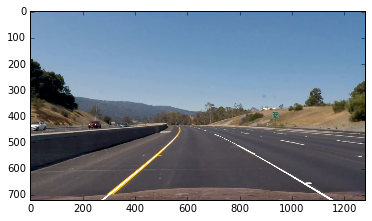

In [37]:
output = 'project_output.mp4'
clip1 = VideoFileClip("project_video.mp4").subclip(0,5)
output_clip = clip1.fl_image(image_pipeline) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)

In [38]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))